In [1]:
!echo "Last updated: `date`"

Last updated: Thu Jul 23 21:17:05 PDT 2020


In [5]:
# Libraries
import json
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS, HMC
import torch
import torch.distributions.constraints as constraints
from torch.nn.functional import pad
from tqdm import trange

# For ADVI
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.optim import Adam

# For GP
import pyro.contrib.gp as gp

# See:
# http://docs.pyro.ai/en/stable/contrib.gp.html
# https://pyro.ai/examples/gp.html

In [21]:
# Taken from: https://pyro.ai/examples/gp.html

# Note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)

def plot(plot_observed_data=False, plot_predictions=False, n_prior_samples=0,
         model=None, kernel=None, n_test=500):

    plt.figure(figsize=(12, 6))
    if plot_observed_data:
        plt.plot(X.numpy(), y.numpy(), 'kx')
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        plt.plot(Xtest.numpy(), mean.numpy(), 'r', lw=2)  # plot the mean
        plt.fill_between(Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
                         (mean - 2.0 * sd).numpy(),
                         (mean + 2.0 * sd).numpy(),
                         color='C0', alpha=0.3)
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (model.noise if type(model) != gp.models.VariationalSparseGP
                 else model.likelihood.variance)
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))
        plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    plt.xlim(-0.5, 5.5)

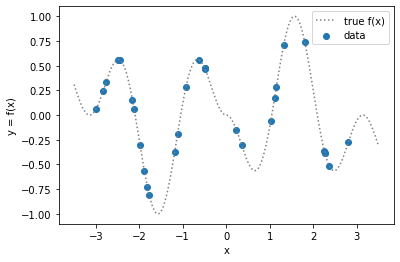

In [3]:
# Read data.
path_to_data = '../data/gp-data-N30.json'
simdata = json.load(open(path_to_data))

# Plot data and true function.
plt.scatter(simdata['x'], simdata['f'], label='data')
plt.plot(simdata['x_true'], simdata['f_true'], ls=':', c='grey', label='true f(x)')
plt.xlabel('x')
plt.ylabel('y = f(x)')
plt.legend();

In [54]:
# Store data as torch.tensors.
X = torch.tensor(simdata['x']).reshape(len(simdata['x']), 1)
y = torch.tensor(simdata['f'])

# Define squared exponential covariance function.
cov_fn = gp.kernels.RBF(input_dim=1)

# Define GP regression model.
gpr = gp.models.GPRegression(X, y, cov_fn, noise=torch.tensor(1e-3))

# Place priors on GP covariance function parameters.
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(-2, 0.1))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

In [58]:
### NUTS ###
pyro.clear_param_store()

# Set random seed for reproducibility.
pyro.set_rng_seed(1)

# Set up HMC sampler.
kernel = HMC(gpr.model, step_size=0.01, trajectory_length=1, target_accept_prob=0.8,
             adapt_step_size=False, adapt_mass_matrix=False)
hmc = MCMC(kernel, num_samples=1000, warmup_steps=1000)
hmc.run()

Warmup:  22%|██▎       | 450/2000 [01:55,  3.91it/s, step size=1.00e-02, acc. prob=0.999]

KeyboardInterrupt: 

In [116]:
### NUTS ###
pyro.clear_param_store()

# Set random seed for reproducibility.
pyro.set_rng_seed(1)

# Set up NUTS sampler.
kernel = NUTS(gpr.model, target_accept_prob=0.8)
nuts = MCMC(kernel, num_samples=1000, warmup_steps=1000)
%time nuts.run()

# Get posterior samples
nuts_posterior_samples = nuts.get_samples()

Sample: 100%|██████████| 2000/2000 [00:25, 79.81it/s, step size=8.81e-01, acc. prob=0.916]

CPU times: user 1min 15s, sys: 337 ms, total: 1min 15s
Wall time: 25.1 s


Text(0, 0.5, 'density')

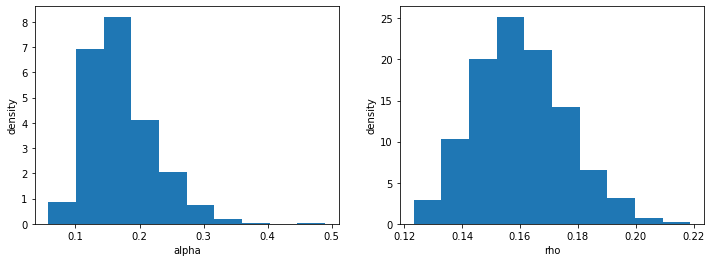

In [163]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(nuts_posterior_samples['kernel.variance'], density=True)
plt.xlabel('alpha')
plt.ylabel('density');

plt.subplot(1, 2, 2)
plt.hist(nuts_posterior_samples['kernel.lengthscale'], density=True)
plt.xlabel('rho')
plt.ylabel('density')

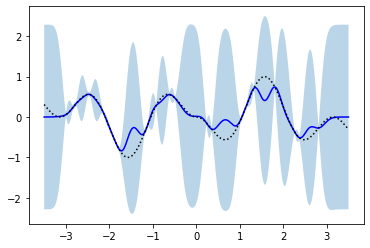

In [162]:
X_new = torch.tensor(simdata['x_true'])
X_new = X_new.reshape(X_new.shape[0], 1)

mean, cov = gpr(X_new)
mean = mean.detach()
cov = cov.detach()

# FIXME: These are not right.
plt.plot(X_new.numpy()[:, 0], mean.numpy(), c='blue')
plt.plot(X_new.numpy()[:, 0], simdata['f_true'], c='black', ls=':')
plt.fill_between(X_new.numpy()[:, 0],
                 mean.detach().numpy() + 2 * cov.sqrt().numpy(),
                 mean.detach().numpy() - 2 * cov.sqrt().numpy(), alpha=0.3)